# Super Resolution with PaddleGAN and OpenVINO™

This notebook demonstrates converting the RealSR (real-world super-resolution) model from [PaddlePaddle/PaddleGAN](https://github.com/PaddlePaddle/PaddleGAN) to OpenVINO Intermediate Representation (OpenVINO IR) format, and shows inference results on both the PaddleGAN and OpenVINO IR models.

For more information about the various PaddleGAN superresolution models, refer to the [PaddleGAN documentation](https://github.com/PaddlePaddle/PaddleGAN/blob/develop/docs/en_US/tutorials/single_image_super_resolution.md). For more information about RealSR, see the [research paper](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w31/Ji_Real-World_Super-Resolution_via_Kernel_Estimation_and_Noise_Injection_CVPRW_2020_paper.pdf) from CVPR 2020.

This notebook works best with small images (up to 800x600 resolution).


#### Table of contents:

- [Imports](#Imports)
- [Settings](#Settings)
- [Inference on PaddlePaddle Model](#Inference-on-PaddlePaddle-Model)
    - [Investigate PaddleGAN Model](#Investigate-PaddleGAN-Model)
    - [Do Inference](#Do-Inference)
- [Convert PaddleGAN Model to ONNX and OpenVINO IR](#Convert-PaddleGAN-Model-to-ONNX-and-OpenVINO-IR)
    - [Convert PaddlePaddle Model to ONNX](#Convert-PaddlePaddle-Model-to-ONNX)
    - [Convert ONNX Model to OpenVINO IR with Model Conversion Python API](#Convert-ONNX-Model-to-OpenVINO-IR-with-Model-Conversion-Python-API)
- [Do Inference on OpenVINO IR Model](#Do-Inference-on-OpenVINO-IR-Model)
    - [Select inference device](#Select-inference-device)
    - [Show an Animated GIF](#Show-an-Animated-GIF)
    - [Create a Comparison Video](#Create-a-Comparison-Video)
        - [Download the video](#Download-the-video)



## Imports
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import platform

%pip install -q "openvino==2023.3.0"

%pip install -q "paddlepaddle>=2.5.1" "paddle2onnx>=0.6"

%pip install -q "imageio==2.9.0" "imageio-ffmpeg" "numba>=0.53.1" "easydict" "munch" "natsort"
%pip install -q "git+https://github.com/PaddlePaddle/PaddleGAN.git" --no-deps
%pip install -q scikit-image

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

In [2]:
import time
import warnings
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import paddle
from IPython.display import HTML, FileLink, ProgressBar, clear_output, display
from IPython.display import Image as DisplayImage
from PIL import Image
from paddle.static import InputSpec
from ppgan.apps import RealSRPredictor

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import NotebookAlert, download_file

## Settings
[back to top ⬆️](#Table-of-contents:)


In [3]:
# The filenames of the downloaded and converted models.
MODEL_NAME = "paddlegan_sr"
MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / MODEL_NAME
ir_path = model_path.with_suffix(".xml")
onnx_path = model_path.with_suffix(".onnx")

%matplotlib inline

## Inference on PaddlePaddle Model
[back to top ⬆️](#Table-of-contents:)

### Investigate PaddleGAN Model
[back to top ⬆️](#Table-of-contents:)

The [PaddleGAN documentation](https://github.com/PaddlePaddle/PaddleGAN) explains how to run the model with `sr.run()` method. Find out what that function does, and check other relevant functions that are called from that function. Adding `??` to the methods shows the docstring and source code.

In [4]:
# Running this cell will download the model weights if they have not been downloaded before.
# This may take a while.
sr = RealSRPredictor()

[04/10 22:32:20] ppgan INFO: Found /home/Lawrence/.cache/ppgan/DF2K_JPEG.pdparams


### Do Inference
[back to top ⬆️](#Table-of-contents:)

To show inference on the PaddlePaddle model, set `PADDLEGAN_INFERENCE` to `True` in the cell below. Keep in mind that performing inference may take some time.

In [5]:
# Load the image from openvino storage
IMAGE_PATH = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_tulips.jpg",
    directory="data"
)

'data/coco_tulips.jpg' already exists.


## Convert PaddleGAN Model to ONNX and OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

To convert the PaddlePaddle model to OpenVINO IR, first convert the model to ONNX, and then convert the ONNX model to the OpenVINO IR format.

### Convert PaddlePaddle Model to ONNX
[back to top ⬆️](#Table-of-contents:)


In [6]:
# Ignore PaddlePaddle warnings:
# The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1).
warnings.filterwarnings("ignore")
sr.model.eval()
# ONNX export requires an input shape in this format as a parameter.
# Both OpenVINO and Paddle support `-1` placeholder for marking flexible dimensions
input_shape = [-1, 3, -1, -1]
x_spec = InputSpec(input_shape, "float32", "x")
paddle.onnx.export(sr.model, str(model_path), input_spec=[x_spec], opset_version=13)

2024-04-10 22:32:32 [INFO]	Static PaddlePaddle model saved in model/paddle_model_static_onnx_temp_dir.


I0410 22:32:32.408692 1548339 program_interpreter.cc:212] New Executor is Running.


[Paddle2ONNX] Start to parse PaddlePaddle model...
[Paddle2ONNX] Model file path: model/paddle_model_static_onnx_temp_dir/model.pdmodel
[Paddle2ONNX] Paramters file path: model/paddle_model_static_onnx_temp_dir/model.pdiparams
[Paddle2ONNX] Start to parsing Paddle model...
[Paddle2ONNX] Use opset_version = 13 for ONNX export.
[Paddle2ONNX] PaddlePaddle model is exported as ONNX format now.
2024-04-10 22:32:37 [INFO]	ONNX model saved in model/paddlegan_sr.onnx.


### Convert ONNX Model to OpenVINO IR with [Model Conversion Python API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html)
[back to top ⬆️](#Table-of-contents:)


In [7]:
print("Exporting ONNX model to OpenVINO IR... This may take a few minutes.")

model = ov.convert_model(
    onnx_path,
    input=input_shape
)

# Serialize model in IR format
ov.save_model(model, str(ir_path))

Exporting ONNX model to OpenVINO IR... This may take a few minutes.


## Do Inference on OpenVINO IR Model
[back to top ⬆️](#Table-of-contents:)


In [8]:
# Read the network and get input and output names.
core = ov.Core()
# Alternatively, the model obtained from `ov.convert_model()` may be used here
model = core.read_model(model=ir_path)
input_layer = model.input(0)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [10]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=9, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'GPU.3', 'GPU.4', 'GPU.5',…

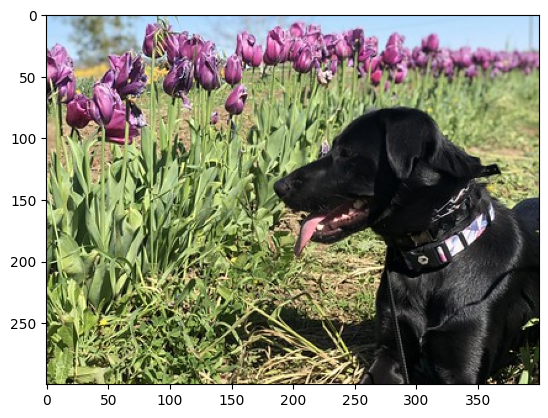

In [11]:
image = cv2.cvtColor(cv2.imread(str(IMAGE_PATH)), cv2.COLOR_BGR2RGB)
if max(image.shape) > 800:
    NotebookAlert(
        f"This image has shape {image.shape}. The notebook works best with images with "
        "a maximum side of 800x600. Larger images may work well, but inference may "
        "be slow",
        "warning",
    )
plt.imshow(image)

In [12]:
# Load the network to the CPU device (this may take a few seconds).
compiled_model = core.compile_model(model=model, device_name=device.value)
output_layer = compiled_model.output(0)

In [41]:
padded_v2 = np.zeros((600, 600, 3), dtype=np.uint8)
padded_v2[:h, :w] = image
padded_v2_input = padded_v2.transpose(2, 0, 1)[None, :, :, :] / 255
padded_v2_result = compiled_model([padded_v2_input])[output_layer]
padded_v2_super = (padded_v2_result.squeeze() * 255).clip(0, 255).astype(np.uint8).transpose(1, 2, 0)
padded_v2_cropped = padded_v2_super[:h*4, :w*4]
padded_v2_cropped.shape

(1200, 1600, 3)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

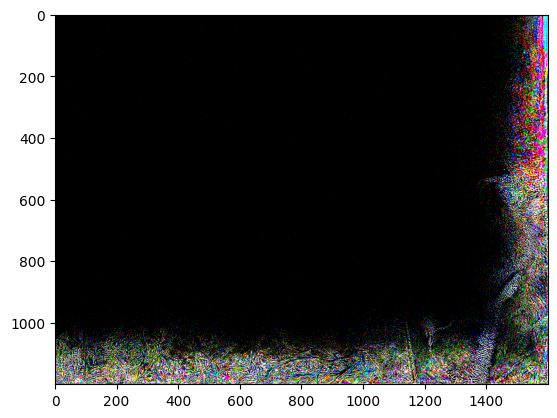

In [43]:
plt.imshow(padded_v2_cropped - image_super)
np.unique(padded_v2_cropped - image_super, return_counts=True)

In [13]:
 # Convert the image to the network input shape and divide pixel values by 255.
# See the "Investigate PaddleGAN model" section.
input_image = image.transpose(2, 0, 1)[None, :, :, :] / 255
start_time = time.perf_counter()
# Do inference.
ir_result = compiled_model([input_image])[output_layer]
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Inference duration: {duration:.2f} seconds")

Inference duration: 5.34 seconds


In [14]:
# Get the result array in CHW format.
result_array = ir_result.squeeze()
# Convert the array to an image with the same method as PaddleGAN:
# Multiply by 255, clip values between 0 and 255, convert to a HWC INT8 image.
# See the "Investigate PaddleGAN model" section.
image_super = (result_array * 255).clip(0, 255).astype("uint8").transpose((1, 2, 0))

In [ ]:
plt.imshow(padded_super_cropped - image_super)
np.unique(padded_super_cropped - image_super, return_counts=True)

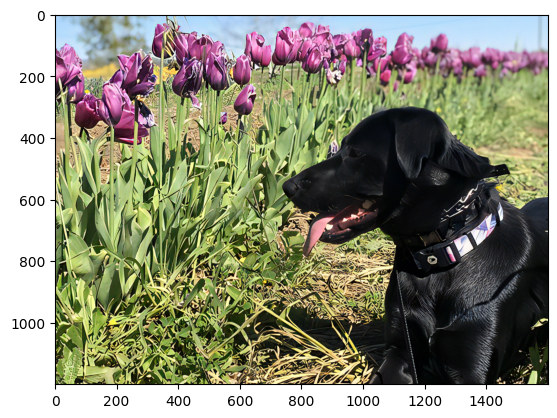

In [15]:
plt.imshow(image_super)

# PySDK version

In [13]:
# make sure PySDK and degirum-tools is installed
!pip show degirum || pip install -q degirum
!pip show degirum-tools || pip install -q degirum-tools

In [1]:
import degirum as dg
import degirum_tools as dgtools
import cv2
import numpy as np
from superres_postprocessor import SuperResolutionResults, preprocess

model_name = 'paddlegan_realsr--600x600_float_openvino_cpu_1'
zoo = dg.connect(dg.CLOUD, 'https://cs.degirum.com/degirum/super_resolution', dgtools.get_token())
model = zoo.load_model(model_name, image_backend="opencv", input_image_format="RAW")

model.inference_timeout_s = 180
SuperResolutionResults.resize_factor = 4
model.custom_postprocessor = SuperResolutionResults

input = cv2.imread('data/coco_tulips.jpg')
processed_input = preprocess(input, model)

results = model(processed_input)

400
300


In [16]:
import degirum as dg
import degirum_tools as dgtools
import cv2
import numpy as np
import importlib
importlib.reload(superres_postprocessor)

from superres_postprocessor import SuperResolutionResults, preprocess


model_name = 'paddlegan_realsr--600x600_float_openvino_cpu_1'
zoo = dg.connect(dg.CLOUD, 'https://cs.degirum.com/degirum/yolov9', dgtools.get_token())
model = zoo.load_model(model_name)

model.inference_timeout_s = 180
SuperResolutionResults.resize_factor = 4
model.custom_postprocessor = SuperResolutionResults

input = cv2.imread('data/coco_tulips.jpg')
processed_input = preprocess(input, model)

padded_v2 = np.zeros((600, 600, 3), dtype=np.uint8)
ph, pw, _ = image.shape
padded_v2[:ph, :pw] = image
padded_v2_input = padded_v2.transpose(2, 0, 1)[None, :, :, :] / 255
padded_v2_input = padded_v2_input.astype(np.float32)
test = model(padded_v2_input)


600
600
400
300


DegirumException: Failed to perform model 'degirum/yolov9/paddlegan_realsr--600x600_float_openvino_cpu_1' inference: cannot reshape array of size 17280000 into shape (1,3,12,2400)

## Compare results

Subtract image from each other. The perfect validation should be all zeros which should result in a black image. Any other color is a differing result at that pixel.

In [42]:
np.unique(results.image_overlay - image_super, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

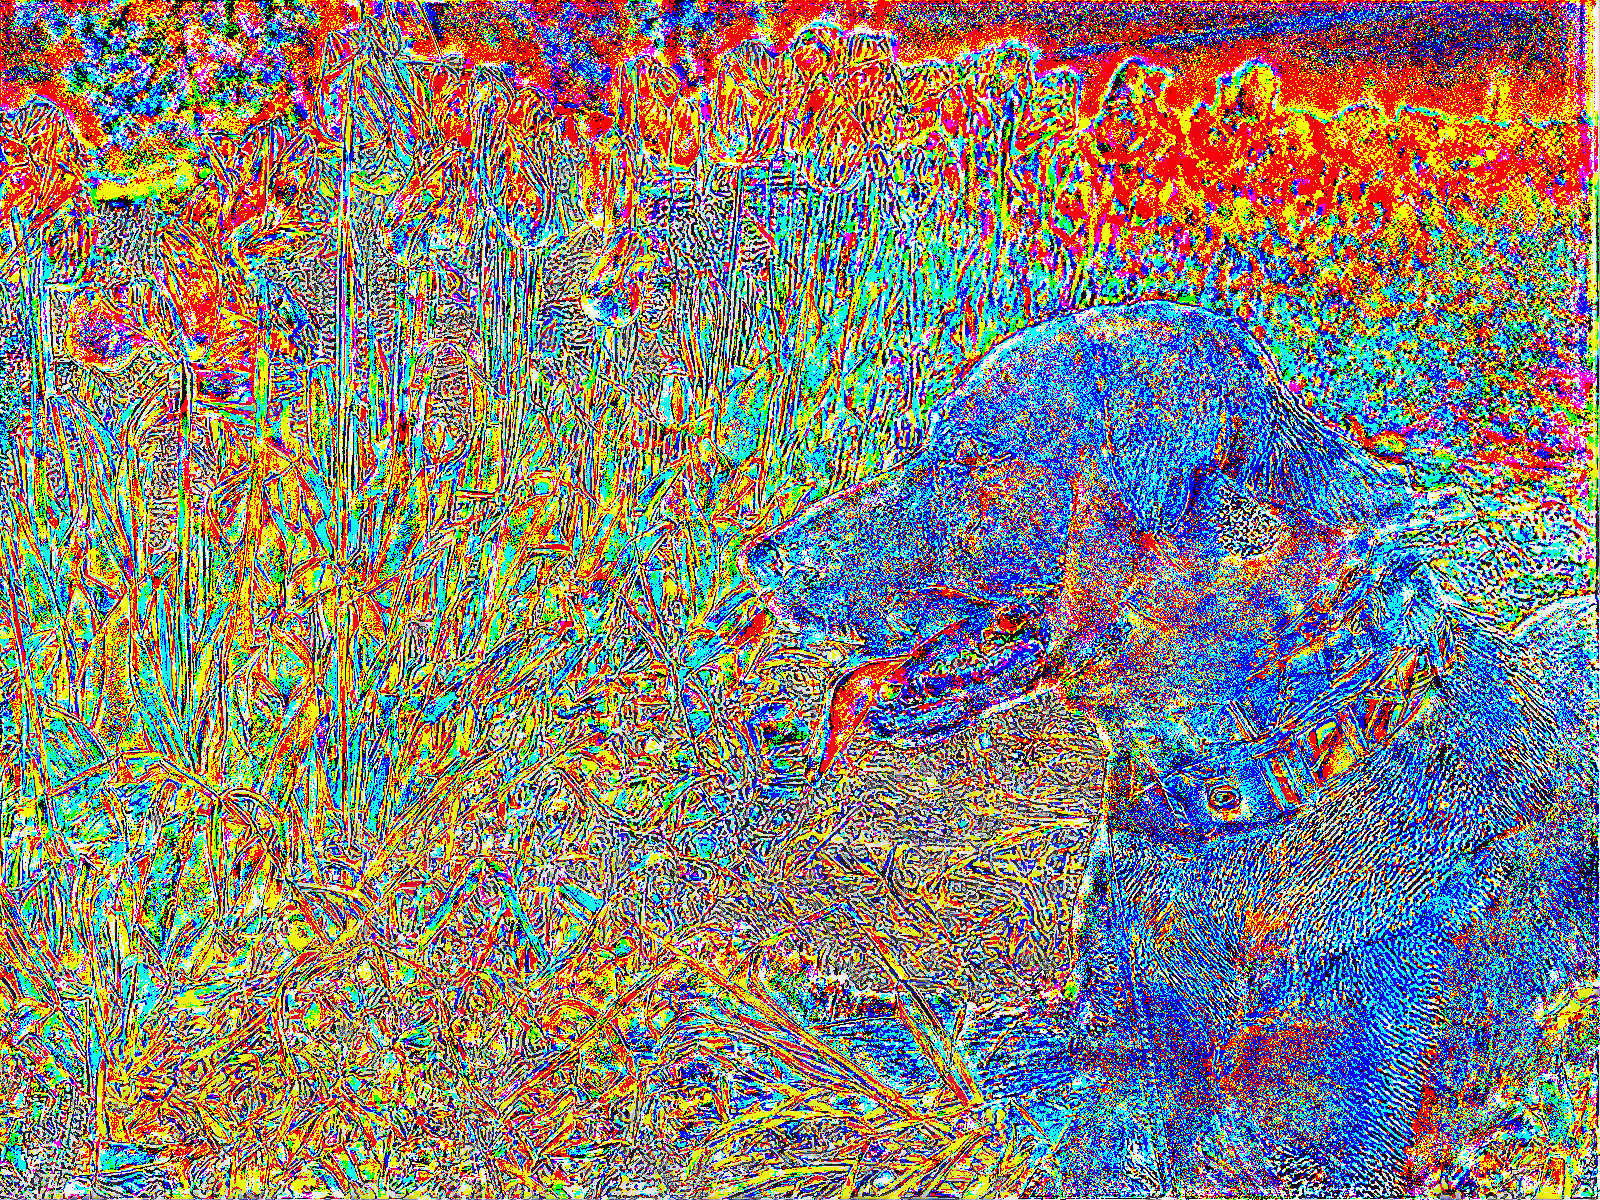

In [43]:
from PIL import Image
Image.fromarray(results.image_overlay - image_super)

In [44]:
image_super

array([[[172, 209, 247],
        [169, 212, 249],
        [178, 210, 251],
        ...,
        [189, 216, 244],
        [190, 216, 255],
        [197, 226, 255]],

       [[175, 201, 240],
        [169, 203, 242],
        [171, 207, 247],
        ...,
        [191, 223, 250],
        [184, 214, 251],
        [191, 209, 250]],

       [[168, 205, 244],
        [171, 207, 252],
        [172, 208, 250],
        ...,
        [186, 222, 255],
        [182, 218, 252],
        [187, 222, 253]],

       ...,

       [[103, 117,  43],
        [ 75,  92,  19],
        [ 83, 100,  30],
        ...,
        [ 45,  32,  15],
        [ 20,  19,  13],
        [ 17,  14,   8]],

       [[104, 120,  69],
        [ 49,  66,   2],
        [ 49,  73,   2],
        ...,
        [  1,   0,   0],
        [ 21,  23,  15],
        [ 18,  17,  16]],

       [[124, 129,  93],
        [ 81,  95,  31],
        [ 90, 114,  36],
        ...,
        [ 22,  24,  13],
        [ 27,  23,  27],
        [ 16,  12,   8]]

In [45]:
results.image_overlay

array([[[155, 214, 248],
        [182, 218, 255],
        [177, 218, 255],
        ...,
        [158, 187, 245],
        [173, 179, 229],
        [148, 153, 162]],

       [[153, 197, 248],
        [169, 215, 255],
        [175, 212, 253],
        ...,
        [172, 209, 245],
        [167, 196, 229],
        [129, 154, 171]],

       [[168, 213, 255],
        [170, 218, 255],
        [171, 213, 252],
        ...,
        [168, 207, 248],
        [178, 199, 244],
        [143, 159, 183]],

       ...,

       [[148, 169,  90],
        [146, 175,  81],
        [133, 166,  74],
        ...,
        [117, 100,  91],
        [ 17,  17,  16],
        [  6,   0,   0]],

       [[ 79,  94,  42],
        [ 82, 100,  51],
        [101,  93,  48],
        ...,
        [ 49,  51,  39],
        [  2,  11,   4],
        [  0,   1,   0]],

       [[  1,   8,   0],
        [  7,   0,   0],
        [ 18,  15,  22],
        ...,
        [  0,   2,   0],
        [  0,   2,   3],
        [  0,   0,   2]]

True